# 1. Imports

In [1]:
from build_model_multinomial import build_v2g_model_multinomial, evaluate_subset, TRANSFORMERS, text_to_code_q6, build_v2g_model_multinomial_from_df
from build_model_logistic import build_v2g_model_binary_from_df
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from get_data import init_column_map, pull_data_rowwise
import pandas as pd

import itertools
from sklearn.model_selection import cross_val_score

# 2. Model setup

In [2]:
## For the input variables:

'''

Q9 - How familiar are you with the term Vehicle-to-Grid (V2G) (also known as bidirectional charging)?
Q2 - Approximately how many kilometres do you drive per year?
Q8 - Which of the following do you currently have at your home? 
(Q8 is broken down as:)
    Q8_1 - Solar panels 
    Q8_2 - Home battery
    Q8_99 - Neither
'''

'\n\nQ9 - How familiar are you with the term Vehicle-to-Grid (V2G) (also known as bidirectional charging)?\nQ2 - Approximately how many kilometres do you drive per year?\nQ8 - Which of the following do you currently have at your home? \n(Q8 is broken down as:)\n    Q8_1 - Solar panels \n    Q8_2 - Home battery\n    Q8_99 - Neither\n'

In [3]:
input_variables = [
    'Q1_1',
    'Q1_2',
    'Q1_3',
    'Q1_4',
    'Q1_99',
    'Q9',
    'Q2',
    'Q8_1',
    'Q8_2',
    'Q8_99'
    ]


target_variable = 'Q10_2'  # "I would be interested in installing V2G..."
csv_file = './data/survey_pre_processed_data.csv'

In [4]:
q10_2_categories = [
    "Strongly disagree",
    "Somewhat disagree",
    "Neither agree nor disagree",
    "Somewhat agree",
    "Strongly agree"
    ]

input_variables_names = [
    'Owns Petrol/Diesel car',
    'Owns Electric vehicle',
    'Plug-in Hybrid vehicle',
    'Hybrid vehicle',
    'I don’t own a car',
    'How familiar are you with V2G?',
    'How many kilometres do you drive per year?',
    'Owns Solar Panels',
    'Owns Home battery',
    'Owns neither Solar nor Battery'
]

In [5]:
init_column_map(csv_file)

In [6]:
##########################################
# 0) Define your Q6 (weekdays) columns by vehicle + time
##########################################
# "Q6ax1" => weekdays, x1 => petrol/diesel
# "Q6ax2" => weekdays, x2 => electric
# "Q6ax3" => weekdays, x3 => plug-in hybrid
# "Q6ax4" => weekdays, x4 => hybrid

# Each has 3 time periods: _1 => 10am-3pm, _2 => 4pm-9pm, _3 => 9pm-6am

q6a_petrol = ["Q6ax1_1","Q6ax1_2","Q6ax1_3"]       # weekdays, petrol/diesel
q6a_ev     = ["Q6ax2_1","Q6ax2_2","Q6ax2_3"]       # weekdays, EV
q6a_plughyb= ["Q6ax3_1","Q6ax3_2","Q6ax3_3"]       # weekdays, plug-in hybrid
q6a_hybrid = ["Q6ax4_1","Q6ax4_2","Q6ax4_3"]       # weekdays, hybrid

# Combine them all for weekdays
q6a_cols = q6a_petrol + q6a_ev + q6a_plughyb + q6a_hybrid

In [7]:
##########################################
# Also define the demographic columns
##########################################
demo_cols = ["gender","colour_plus","region","Q21","Q22","AgeBand","Q24"]

In [8]:
##########################################
# Pull the data from CSV
##########################################
init_column_map(csv_file)

# We'll get both Q6a columns and the demographic columns
columns_of_interest = q6a_cols + demo_cols + input_variables + [target_variable]
rows = pull_data_rowwise(columns_of_interest, csv_file)

# Make a DataFrame
df = pd.DataFrame(rows, columns=columns_of_interest)

df

,Q6ax1_1,Q6ax1_2,Q6ax1_3,Q6ax2_1,Q6ax2_2,Q6ax2_3,Q6ax3_1,Q6ax3_2,Q6ax3_3,Q6ax4_1,...,Q1_2,Q1_3,Q1_4,Q1_99,Q9,Q2,Q8_1,Q8_2,Q8_99,Q10_2
0,3,5,5,,,,,,,,...,0,0,0,0,Somewhat familiar,"Less than 10,000",1,0,0,Neither agree nor disagree
1,5,5,5,5,5,5,,,,,...,1,0,0,0,Very familiar,"Less than 10,000",1,1,0,Strongly agree
2,2,1,2,,,,,,,,...,0,0,0,0,Not at all familiar,"20,001-50,000",0,0,1,Strongly disagree
3,,,,,,,,,,0 - Weekdays,...,0,0,1,0,Not at all familiar,"Less than 10,000",0,0,1,Somewhat disagree
4,5,5,5,4,4,4,,,,2,...,1,0,1,0,Very familiar,"20,001-50,000",1,1,0,Somewhat agree
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353,,,,1,3,5,,,,,...,1,0,0,0,Somewhat familiar,"10,000-20,000",1,1,0,Strongly agree
1354,5,5,5,,,,,,,,...,0,0,0,0,Somewhat familiar,"Less than 10,000",0,0,1,Neither agree nor disagree
1355,4,4,5,4,4,5,,,,,...,1,0,0,0,Very familiar,"10,000-20,000",1,0,0,Strongly agree
1356,,,,3,5,5,,,,,...,1,0,0,0,Very familiar,"10,000-20,000",0,0,1,Somewhat agree


In [9]:
# Ensure "0 - Weekdays" is converted correctly
for col in q6a_cols:
    df[col] = df[col].replace("0 - Weekdays", 0)  # Convert "0 - Weekdays" to 0
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert all values to numbers

# Debugging: Check unique values in each column
for col in q6a_cols:
    print(f"Unique values in {col}: {df[col].dropna().unique()}")

Unique values in Q6ax1_1: [3. 5. 2. 4. 0. 1.]
Unique values in Q6ax1_2: [5. 1. 3. 2. 4. 0.]
Unique values in Q6ax1_3: [5. 2. 0. 4. 3. 1.]
Unique values in Q6ax2_1: [5. 4. 3. 1. 2. 0.]
Unique values in Q6ax2_2: [5. 4. 3. 2. 0. 1.]
Unique values in Q6ax2_3: [5. 4. 3. 1. 0. 2.]
Unique values in Q6ax3_1: [3. 1. 4. 0. 2. 5.]
Unique values in Q6ax3_2: [5. 4. 2. 3. 1.]
Unique values in Q6ax3_3: [5. 2. 3. 4.]
Unique values in Q6ax4_1: [0. 2. 5. 4. 3. 1.]
Unique values in Q6ax4_2: [5. 2. 3. 0. 4. 1.]
Unique values in Q6ax4_3: [5. 3. 0. 1. 4. 2.]


In [10]:
df["Charging_10am_3pm"] = df[
    [col for col in (q6a_petrol[0::3] + q6a_ev[0::3] + q6a_plughyb[0::3] + q6a_hybrid[0::3]) if col in df.columns]
].mean(axis=1)

df["Charging_4pm_9pm"] = df[
    [col for col in (q6a_petrol[1::3] + q6a_ev[1::3] + q6a_plughyb[1::3] + q6a_hybrid[1::3]) if col in df.columns]
].mean(axis=1)

df["Charging_9pm_6am"] = df[
    [col for col in (q6a_petrol[2::3] + q6a_ev[2::3] + q6a_plughyb[2::3] + q6a_hybrid[2::3]) if col in df.columns]
].mean(axis=1)


In [11]:
# Make a copy of TRANSFORMERS and update it with Q6a mappings
TRANSFORMERS_q6a = TRANSFORMERS.copy()

In [12]:
# Update with Q6a_* variables (charging behavior questions)
TRANSFORMERS_q6a.update({
    **{q: text_to_code_q6 for q in q6a_petrol},  
    **{q: text_to_code_q6 for q in q6a_ev},      
    **{q: text_to_code_q6 for q in q6a_plughyb}, 
    **{q: text_to_code_q6 for q in q6a_hybrid}   
})

In [13]:
print("TRANSFORMERS_q6a keys:", list(TRANSFORMERS_q6a.keys())[:10])  # Print first 10 keys


TRANSFORMERS_q6a keys: ['Q9', 'Q2', 'Q1_1', 'Q1_2', 'Q1_3', 'Q1_4', 'Q1_99', 'Q8_1', 'Q8_2', 'Q8_99']


In [14]:
df

,Q6ax1_1,Q6ax1_2,Q6ax1_3,Q6ax2_1,Q6ax2_2,Q6ax2_3,Q6ax3_1,Q6ax3_2,Q6ax3_3,Q6ax4_1,...,Q1_99,Q9,Q2,Q8_1,Q8_2,Q8_99,Q10_2,Charging_10am_3pm,Charging_4pm_9pm,Charging_9pm_6am
0,3.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,Somewhat familiar,"Less than 10,000",1,0,0,Neither agree nor disagree,3.000000,5.000000,5.000000
1,5.0,5.0,5.0,5.0,5.0,5.0,NaN,NaN,NaN,NaN,...,0,Very familiar,"Less than 10,000",1,1,0,Strongly agree,5.000000,5.000000,5.000000
2,2.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,Not at all familiar,"20,001-50,000",0,0,1,Strongly disagree,2.000000,1.000000,2.000000
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,0,Not at all familiar,"Less than 10,000",0,0,1,Somewhat disagree,0.000000,5.000000,5.000000
4,5.0,5.0,5.0,4.0,4.0,4.0,NaN,NaN,NaN,2.0,...,0,Very familiar,"20,001-50,000",1,1,0,Somewhat agree,3.666667,3.666667,4.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353,NaN,NaN,NaN,1.0,3.0,5.0,NaN,NaN,NaN,NaN,...,0,Somewhat familiar,"10,000-20,000",1,1,0,Strongly agree,1.000000,3.000000,5.000000
1354,5.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,Somewhat familiar,"Less than 10,000",0,0,1,Neither agree nor disagree,5.000000,5.000000,5.000000
1355,4.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,NaN,NaN,...,0,Very familiar,"10,000-20,000",1,0,0,Strongly agree,4.000000,4.000000,5.000000
1356,NaN,NaN,NaN,3.0,5.0,5.0,NaN,NaN,NaN,NaN,...,0,Very familiar,"10,000-20,000",0,0,1,Somewhat agree,3.000000,5.000000,5.000000


In [15]:
df.columns

Index(['Q6ax1_1', 'Q6ax1_2', 'Q6ax1_3', 'Q6ax2_1', 'Q6ax2_2', 'Q6ax2_3',
       'Q6ax3_1', 'Q6ax3_2', 'Q6ax3_3', 'Q6ax4_1', 'Q6ax4_2', 'Q6ax4_3',
       'gender', 'colour_plus', 'region', 'Q21', 'Q22', 'AgeBand', 'Q24',
       'Q1_1', 'Q1_2', 'Q1_3', 'Q1_4', 'Q1_99', 'Q9', 'Q2', 'Q8_1', 'Q8_2',
       'Q8_99', 'Q10_2', 'Charging_10am_3pm', 'Charging_4pm_9pm',
       'Charging_9pm_6am'],
      dtype='object')

In [16]:
# Updated input variables with new charging behavior features
# input_variables_extended = input_variables + ["Charging_10am_3pm", "Charging_4pm_9pm", "Charging_9pm_6am"]
input_variables_extended = input_variables + q6a_ev

#input_variables_names_extended = input_variables_names + ["Charging Behavior (10am-3pm)", "Charging Behavior (4pm-9pm)", "Charging Behavior (9pm-6am)"]
input_variables_names_extended = input_variables_names + ["Charging Behavior EV (10am-3pm)", "Charging Behavior EV (4pm-9pm)", "Charging Behavior EV (9pm-6am)"]

In [17]:
target_variable

'Q10_2'

In [18]:
print("Checking if any feature column is missing data...")
print(df[input_variables_extended].isnull().sum())

print("\nChecking unique values in target variable (Q10_2):")
print(df[target_variable].unique())

print("\nChecking number of non-missing rows in dataset:")
valid_rows = df[input_variables_extended + [target_variable]].dropna().shape[0]
print(f"Valid rows: {valid_rows} / {df.shape[0]}")


Checking if any feature column is missing data...
Q1_1         0
Q1_2         0
Q1_3         0
Q1_4         0
Q1_99        0
Q9           0
Q2           0
Q8_1         0
Q8_2         0
Q8_99        0
Q6ax2_1    590
Q6ax2_2    590
Q6ax2_3    590
dtype: int64

Checking unique values in target variable (Q10_2):
['Neither agree nor disagree' 'Strongly agree' 'Strongly disagree'
 'Somewhat disagree' 'Somewhat agree']

Checking number of non-missing rows in dataset:
Valid rows: 768 / 1358


In [19]:
df[q6a_cols] = df[q6a_cols].fillna(0)

In [35]:
print("Checking if any feature column is missing data...")
print(df[input_variables_extended].isnull().sum())

print("\nChecking unique values in target variable (Q10_2):")
print(df[target_variable].unique())

print("\nChecking number of non-missing rows in dataset:")
valid_rows = df[input_variables_extended + [target_variable]].dropna().shape[0]
print(f"Valid rows: {valid_rows} / {df.shape[0]}")


Checking if any feature column is missing data...
Q1_1       0
Q1_2       0
Q1_3       0
Q1_4       0
Q1_99      0
Q9         0
Q2         0
Q8_1       0
Q8_2       0
Q8_99      0
Q6ax2_1    0
Q6ax2_2    0
Q6ax2_3    0
dtype: int64

Checking unique values in target variable (Q10_2):
['Neither agree nor disagree' 'Strongly agree' 'Strongly disagree'
 'Somewhat disagree' 'Somewhat agree']

Checking number of non-missing rows in dataset:
Valid rows: 1358 / 1358


# 3. Model run

In [24]:
model, X, y, X_test, y_test = build_v2g_model_multinomial(csv_file, input_variables, target_variable, do_normalize=True, test_split_ratio=0.2)

Train accuracy: 0.4621771217712177
Test accuracy: 0.4944649446494465


In [25]:
'''
Each cell is the coefficient that the logistic regression model uses to estimate the “log-odds” of that class, relative to a baseline in a multinomial setting. 
In scikit‐learn’s multinomial logistic regression, each row’s coefficients reflect how that feature (column) pushes the model toward or away from that particular class.

'''

'\nEach cell is the coefficient that the logistic regression model uses to estimate the “log-odds” of that class, relative to a baseline in a multinomial setting. \nIn scikit‐learn’s multinomial logistic regression, each row’s coefficients reflect how that feature (column) pushes the model toward or away from that particular class.\n\n'

In [26]:
input_variables_names

['Owns Petrol/Diesel car',
 'Owns Electric vehicle',
 'Plug-in Hybrid vehicle',
 'Hybrid vehicle',
 'I don’t own a car',
 'How familiar are you with V2G?',
 'How many kilometres do you drive per year?',
 'Owns Solar Panels',
 'Owns Home battery',
 'Owns neither Solar nor Battery']

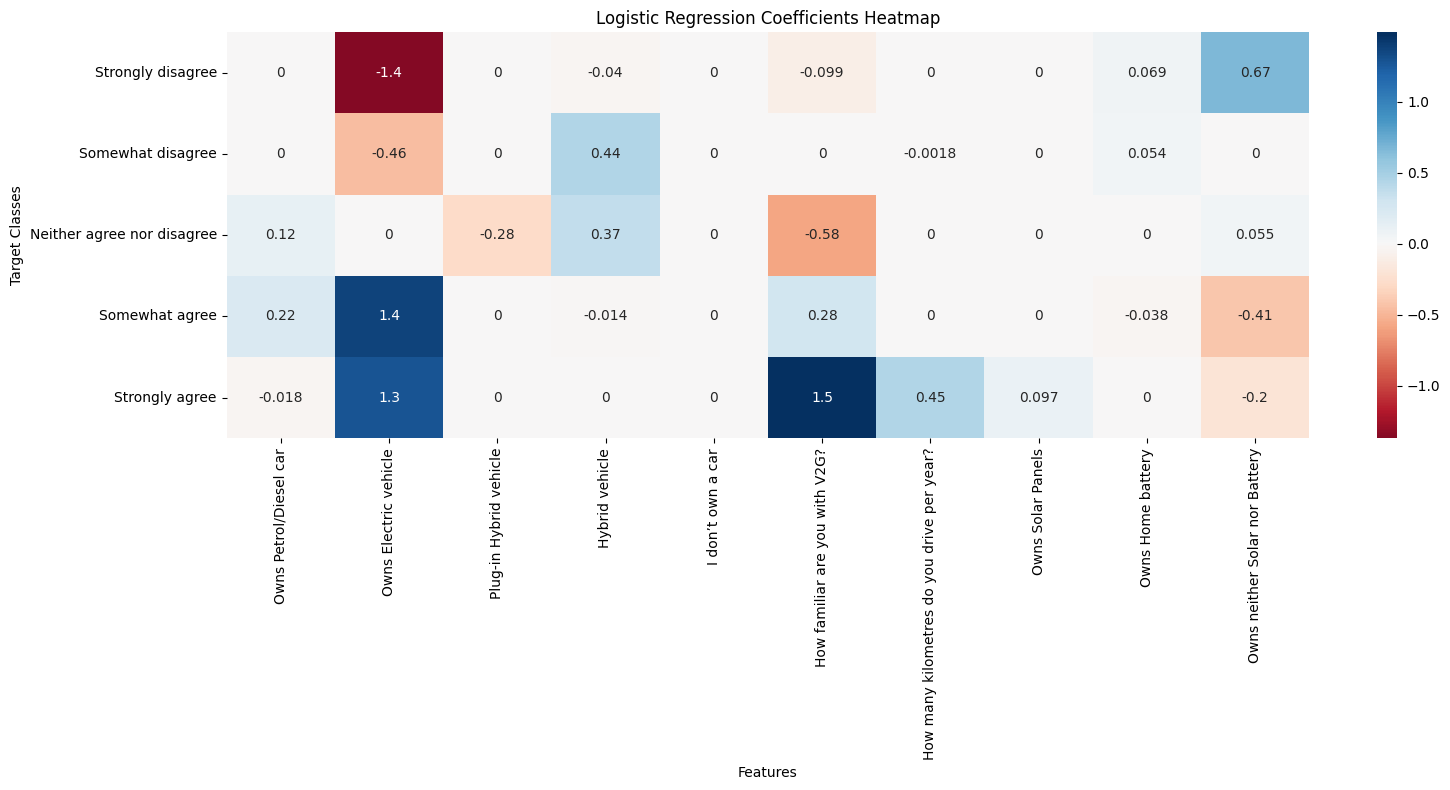

In [27]:
coefs = model.coef_  # shape: (n_classes, n_features)

row_labels = q10_2_categories  
col_labels = input_variables_names  

plt.figure(figsize=(16, 8))
sns.heatmap(
    coefs,
    annot=True,        # display numerical values in the cells
    cmap="RdBu",     
    xticklabels=col_labels,
    yticklabels=row_labels,
    center=0           # ensures 0 is in the middle of the color scale
)
plt.title("Logistic Regression Coefficients Heatmap")
plt.xlabel("Features")
plt.ylabel("Target Classes")
plt.tight_layout()
plt.show()

In [28]:
# Train model with the modified DataFrame (df)
model, X, y, X_test, y_test = build_v2g_model_multinomial_from_df(
    df,  
    input_variables_extended,
    target_variable,
    TRANSFORMERS_q6a, 
    do_normalize=True,
    test_split_ratio=0.2
)

Train Accuracy: 0.470479704797048
Test Accuracy: 0.4981549815498155


In [29]:
# Extract model coefficients
coefs = model.coef_  # Shape: (n_classes, n_features)

# Create a DataFrame for readability
coefs_df = pd.DataFrame(coefs, columns=input_variables_extended, index=model.classes_)

'''# Display coefficients
import ace_tools as tools
tools.display_dataframe_to_user(name="Regression Coefficients", dataframe=coefs_df)
'''

'# Display coefficients\nimport ace_tools as tools\ntools.display_dataframe_to_user(name="Regression Coefficients", dataframe=coefs_df)\n'

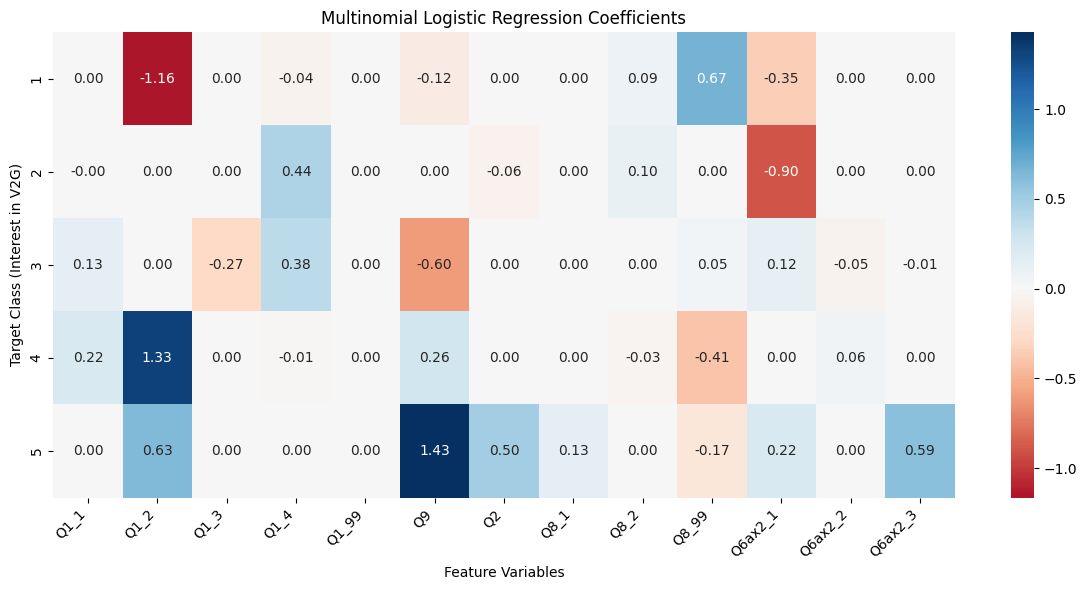

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(coefs_df, annot=True, cmap="RdBu", center=0, fmt=".2f")
plt.title("Multinomial Logistic Regression Coefficients")
plt.xlabel("Feature Variables")
plt.ylabel("Target Class (Interest in V2G)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [31]:
# Update column names to descriptive labels
coefs_df.columns = input_variables_names_extended  # Use extended names including charging behavior

# Update row index to category names
coefs_df.index = q10_2_categories  # Map target classes to their descriptive labels

In [32]:
coefs_df

,Owns Petrol/Diesel car,Owns Electric vehicle,Plug-in Hybrid vehicle,Hybrid vehicle,I don’t own a car,How familiar are you with V2G?,How many kilometres do you drive per year?,Owns Solar Panels,Owns Home battery,Owns neither Solar nor Battery,Charging Behavior EV (10am-3pm),Charging Behavior EV (4pm-9pm),Charging Behavior EV (9pm-6am)
Strongly disagree,0.000000,-1.163223,0.000000,-0.044389,0.0,-0.118977,0.000000,0.000000,0.087911,0.671098,-0.351282,0.000000,0.000000
Somewhat disagree,-0.004679,0.000000,0.000000,0.435519,0.0,0.000000,-0.058144,0.000000,0.103312,0.000000,-0.897475,0.000000,0.000000
Neither agree nor disagree,0.132979,0.000000,-0.273409,0.375975,0.0,-0.603012,0.000000,0.000000,0.000000,0.052314,0.124641,-0.047682,-0.005842
Somewhat agree,0.222963,1.334446,0.000000,-0.012301,0.0,0.264730,0.000000,0.000000,-0.031436,-0.413961,0.000000,0.062985,0.000000
Strongly agree,0.000000,0.628693,0.000000,0.000000,0.0,1.427010,0.496017,0.133248,0.000000,-0.167141,0.223047,0.000000,0.594660


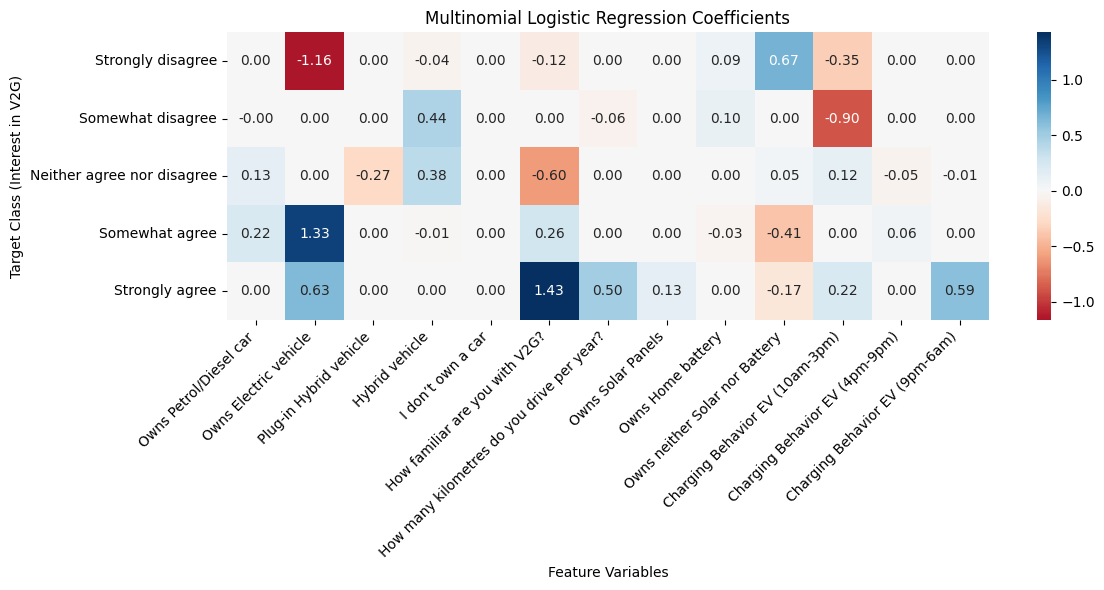

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(coefs_df, annot=True, cmap="RdBu", center=0, fmt=".2f")

plt.title("Multinomial Logistic Regression Coefficients")
plt.xlabel("Feature Variables")
plt.ylabel("Target Class (Interest in V2G)")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


In [36]:
from sklearn.metrics import accuracy_score

# Predict on test set
y_pred = model.predict(X_test)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2%}")


Model Accuracy: 49.82%


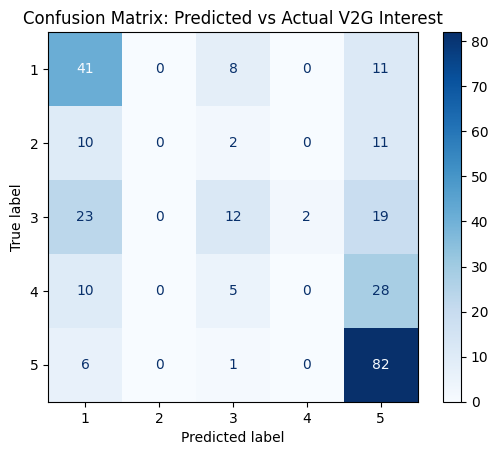

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix: Predicted vs Actual V2G Interest")
plt.show()


In [38]:
coefs_df

,Owns Petrol/Diesel car,Owns Electric vehicle,Plug-in Hybrid vehicle,Hybrid vehicle,I don’t own a car,How familiar are you with V2G?,How many kilometres do you drive per year?,Owns Solar Panels,Owns Home battery,Owns neither Solar nor Battery,Charging Behavior EV (10am-3pm),Charging Behavior EV (4pm-9pm),Charging Behavior EV (9pm-6am)
Strongly disagree,0.000000,-1.163223,0.000000,-0.044389,0.0,-0.118977,0.000000,0.000000,0.087911,0.671098,-0.351282,0.000000,0.000000
Somewhat disagree,-0.004679,0.000000,0.000000,0.435519,0.0,0.000000,-0.058144,0.000000,0.103312,0.000000,-0.897475,0.000000,0.000000
Neither agree nor disagree,0.132979,0.000000,-0.273409,0.375975,0.0,-0.603012,0.000000,0.000000,0.000000,0.052314,0.124641,-0.047682,-0.005842
Somewhat agree,0.222963,1.334446,0.000000,-0.012301,0.0,0.264730,0.000000,0.000000,-0.031436,-0.413961,0.000000,0.062985,0.000000
Strongly agree,0.000000,0.628693,0.000000,0.000000,0.0,1.427010,0.496017,0.133248,0.000000,-0.167141,0.223047,0.000000,0.594660


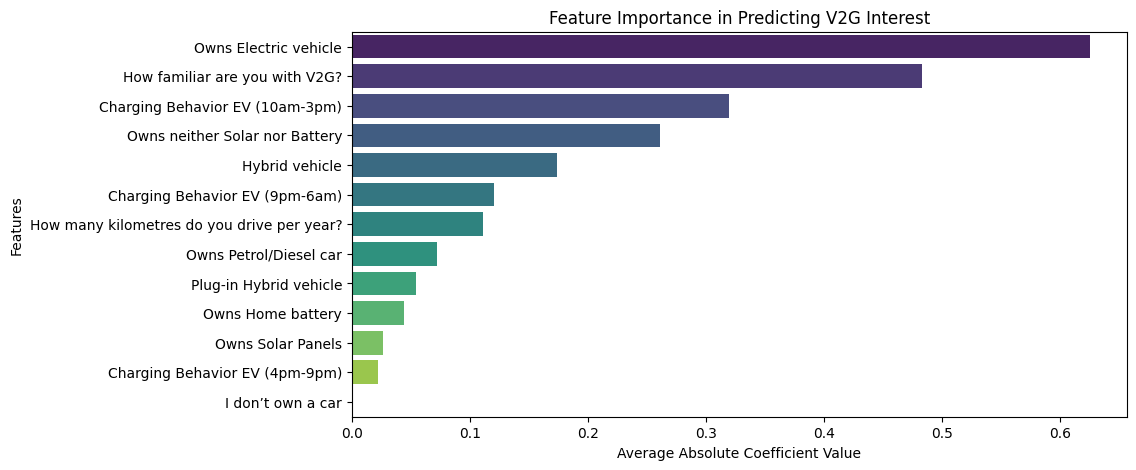

In [39]:
feature_importance = np.abs(coefs_df).mean(axis=0).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importance.values, y=feature_importance.index, palette="viridis")
plt.title("Feature Importance in Predicting V2G Interest")
plt.xlabel("Average Absolute Coefficient Value")
plt.ylabel("Features")
plt.show()


In [ ]:
'''
All else equal, a person with a higher coded value for familiarity with V2G (e.g. ‘Very familiar’ mapped to 3) has a strong push towards ‘Strongly agree’ about installing V2G chargers.

Meanwhile, row 0 (Strongly disagree) for Q9 = -0.44 might appear if the code forced that coefficient negative (or zero). A negative sign would mean that higher familiarity reduces the log-odds of strongly disagreeing.


'''

In [ ]:
# Now let's systematically try all combinations of these variables
best_acc = 0
best_combo = None

for r in range(1, len(input_variables) + 1):
    for subset in itertools.combinations(input_variables, r):
        mean_cv_acc = evaluate_subset(csv_file, subset, target_variable)
        if mean_cv_acc > best_acc:
            best_acc = mean_cv_acc
            best_combo = subset

print("Best subset:", best_combo)
print("Best subset accuracy:", best_acc)

In [ ]:
all_variables = [
    # e.g. EVERY column except those we exclude 
    # or just a subset you're testing
    "Q9", "Q2", "Q8_1", "Q8_2", "Q8_99", # ...
    "Q15_1", "Q15_2", # etc.
]

best_acc = 0
best_combo = None
max_subset_size = 5 

for r in range(1, max_subset_size + 1):
    for subset in itertools.combinations(all_variables, r):
        try:
            acc = evaluate_subset(csv_file, subset, target_variable)
            if acc > best_acc:
                best_acc = acc
                best_combo = subset
        except ValueError as e:
            # Probably "No valid rows found" or some parse error
            # We can skip
            pass

print("Best combo:", best_combo)
print("Best accuracy:", best_acc)

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X)
cm = confusion_matrix(y, y_pred, labels=[1,2,3,4,5])
print(cm)

# 4. Binomial Logsitic Regression

In [ ]:
def text_to_code_q10_2_binary(raw_ans):
    """
    Converts Q10_2 from 5-category responses to binary:
    - "Strongly disagree", "Somewhat disagree", "Neither agree nor disagree" → 0 (Not adopting)
    - "Somewhat agree", "Strongly agree" → 1 (Adopting)
    """
    adopting = {"Somewhat agree", "Strongly agree"}
    return 1 if raw_ans in adopting else 0

In [ ]:
TRANSFORMERS_q6a["Q10_2"] = text_to_code_q10_2_binary

In [ ]:
TRANSFORMERS_q6a

In [ ]:
# Train model with binary logistic regression
model_binary, X_train, y_train, X_test, y_test = build_v2g_model_binary_from_df(
    df,  
    input_variables_extended,  # Keep same features
    target_variable,  
    TRANSFORMERS_q6a,  
    do_normalize=True,
    test_split_ratio=0.2
)

In [ ]:
'''

Positive coefficients → Increase likelihood of adopting V2G
Negative coefficients → Decrease likelihood of adopting V2G
Higher magnitude → Stronger influence on decision

'''

In [ ]:
feature_label_map = {
    "Q1_1": "Owns Petrol/Diesel Car",
    "Q1_2": "Owns Electric Vehicle",
    "Q1_3": "Owns Plug-in Hybrid",
    "Q1_4": "Owns Hybrid",
    "Q1_99": "Does Not Own a Car",
    "Q9": "How Familiar Are You with V2G?",
    "Q2": "How Many Kilometres Do You Drive Per Year?",
    "Q8_1": "Owns Solar Panels",
    "Q8_2": "Owns Home Battery",
    "Q8_99": "Owns Neither Solar nor Battery",
    "Q6ax2_2": "EV at home 4pm-9pm"
}


In [ ]:
coefs_binary_df["Feature"] = coefs_binary_df["Feature"].map(feature_label_map)

In [ ]:
# Sort features by absolute coefficient magnitude for better visualization
coefs_binary_df["abs_coef"] = coefs_binary_df["Coefficient"].abs()
coefs_binary_df = coefs_binary_df.sort_values(by="abs_coef", ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x="Coefficient", y="Feature", data=coefs_binary_df, palette="coolwarm")
plt.title("Feature Importance in Predicting V2G Adoption (Binary Logistic Regression)")
plt.xlabel("Coefficient Value (Log Odds)")
plt.ylabel("Feature (Survey Question)")
plt.axvline(x=0, color='black', linestyle='--')  # Reference line for neutral impact
plt.show()

In [ ]:
# Extract coefficients
coefs_binary = model_binary.coef_[0]  # Shape: (1, n_features), so take [0]

# Create DataFrame for visualization
coefs_binary_df = pd.DataFrame({'Feature': input_variables_extended, 'Coefficient': coefs_binary})
coefs_binary_df.sort_values(by="Coefficient", ascending=False, inplace=True)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x="Coefficient", y="Feature", data=coefs_binary_df, palette="coolwarm")
plt.title("Feature Importance in Predicting V2G Adoption (Binary Logistic Regression)")
plt.xlabel("Coefficient Value (Log Odds)")
plt.ylabel("Feature")
plt.axvline(x=0, color='black', linestyle='--')  # Reference line for neutral impact
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

# Predict on test data
y_pred_binary = model_binary.predict(X_test)

# Compute accuracy
accuracy_binary = accuracy_score(y_test, y_pred_binary)
print(f"Model Accuracy: {accuracy_binary:.2%}")

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_binary = confusion_matrix(y_test, y_pred_binary, labels=[0, 1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm_binary, display_labels=["Not Adopting", "Adopting"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix: Binary V2G Adoption Prediction")
plt.show()

# 5. Individual runs

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import statsmodels.api as sm

# Ensure target variable is numeric
df[target_variable] = df[target_variable].apply(TRANSFORMERS_q6a[target_variable]).astype(int)

# List to store results
results = []

# Loop over each input variable individually
for feature in input_variables_extended:
    print(f"Running Logistic Regression for: {feature}")

    # Convert feature to numeric if needed
    if feature in TRANSFORMERS_q6a:
        X_single = df[feature].apply(TRANSFORMERS_q6a[feature]).values.reshape(-1, 1)
    else:
        X_single = df[[feature]].astype(float).values.reshape(-1, 1)  # Ensure it's numeric

    y = df[target_variable].values  # Ensure y is numeric (0 or 1)

    # Verify the transformation
    print(f"✅ Feature '{feature}' transformed. Unique values: {np.unique(X_single)}")
    print(f"✅ Target variable unique values: {np.unique(y)}")  # Should be [0, 1]

    # Fit logistic regression
    model = LogisticRegression(penalty='l1', solver='liblinear')
    model.fit(X_single, y)

    # Predict & evaluate performance
    y_pred = model.predict(X_single)
    accuracy = accuracy_score(y, y_pred)

    # Get coefficients (odds ratio)
    coef = model.coef_[0][0]
    odds_ratio = np.exp(coef)  # Exponentiate coefficient to get odds ratio

    # Fit logistic regression using statsmodels to get p-value
    X_with_intercept = sm.add_constant(X_single)  # Add intercept for statsmodels
    sm_model = sm.Logit(y, X_with_intercept).fit(disp=0)  # Suppress output
    p_value = sm_model.pvalues[1]  # Extract p-value for feature

    # Store results
    results.append({
        "Feature": feature_label_map.get(feature, feature),  # Use full label if available
        "Accuracy": accuracy,
        "Coefficient": coef,
        "Odds Ratio": odds_ratio,
        "P-value": p_value
    })

# Convert to DataFrame for easier viewing
results_df = pd.DataFrame(results)

# Sort by highest predictive power
results_df = results_df.sort_values(by="Odds Ratio", ascending=False)

Running Logistic Regression for: Q1_1
✅ Feature 'Q1_1' transformed. Unique values: [0 1]
✅ Target variable unique values: [1 2 3 4 5]


ValueError: endog must be in the unit interval.

In [ ]:
results_df

In [ ]:
# Display results
import ace_tools as tools
tools.display_dataframe_to_user(name="Feature Importance (Univariate Logistic Regression)", dataframe=results_df)